# This is the implementation of secrect key exchange using neural networks

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import hamming

## Tree parity machine architecture

In [3]:
class TreeParityMachine:
    def __init__(self, k, n, l, is_discrete=True, seed=None):
        if k < 0:
            raise ValueError(f"Invalid value for k: {k}. Number of hidden units (k) must be non-negative.")
        if n < 0:
            raise ValueError(f"Invalid value for n: {n}. Number of input neurons per hidden unit (n) must be non-negative.")
        if l < 0:
            raise ValueError(f"Invalid value for l: {l}. Weight range (l) must be non-negative.")

        if seed is not None:
          np.random.seed(seed)

        self.k = k  # Number of hidden units
        self.n = n  # Number of input neurons per hidden unit
        self.l = l  # Weight range [-L, L]
        self.is_discrete = is_discrete
        if is_discrete:
          self.weights = np.random.randint(-l, l + 1, (k, n))
        else:
          self.weights = np.random.uniform(-l, l, (k, n))



    def compute_output(self, inputs):
        h = np.sign(np.sum(self.weights * inputs, axis=1))
        h[h == 0] = 1
        return int(np.prod(h))



    def update_weights(self, inputs, tau, lr=1):
        if self.is_discrete:
            if not isinstance(lr, int):
                raise ValueError(f"Learning rate (lr) must be an integer for discrete TPM.")
            if lr > 2 * self.l + 1:
                raise ValueError(f"Learning rate (lr) cannot be greater than 2L+1 ({2 * self.l + 1}) for discrete TPM.")
        else:
            if lr >= 2 * self.l + 1:
                raise ValueError(f"Learning rate (lr) must be less than 2L+1 ({2 * self.l + 1}) for continuous TPM.")

        for i in range(self.k):
            weighted_sum = np.sum(self.weights[i] * inputs[i])
            sign_weighted_sum = np.sign(weighted_sum)

            # Convert 0 to +1 to ensure there is no zero output
            if not sign_weighted_sum:
                sign_weighted_sum = 1

            if sign_weighted_sum == tau:
                self.weights[i] +=  inputs[i] * lr #tau *
                self.weights[i] = np.clip(self.weights[i], -self.l, self.l)


    def synchronize(self, other_tpm, inputs, lr=1):
        tau_A = self.compute_output(inputs)
        tau_B = other_tpm.compute_output(inputs)

        if tau_A == tau_B:
            self.update_weights(inputs, tau_A, lr)
            other_tpm.update_weights(inputs, tau_B, lr)
            return True

        return False



    # Calculate the Manhattan distance between the weights of this TPM and another TPM
    def manhattan_distance(self, other_tpm):
        return np.sum(np.abs(self.weights - other_tpm.get_weights()))



    def point_initialization(self, Number_of_initialization_points):
        initialization_points = []

        # Start with a randomly selected point
        current_point = np.random.randint(-self.l, self.l + 1, (self.k, self.n))
        initialization_points.append(current_point)

        # Select the remaining points
        for _ in range(1, Number_of_initialization_points):
            distances = []
            for _ in range(100):  # It selects from 100 points.
                candidate_point = np.random.randint(-self.l, self.l + 1, (self.k, self.n))
                min_distance = min(np.sum(np.abs(candidate_point - point)) for point in initialization_points)
                distances.append((min_distance, candidate_point))

            # Select the candidate point with the maximum minimum distance to the current set of points
            max_distance_point = max(distances, key=lambda x: x[0])[1]
            initialization_points.append(max_distance_point)

        return initialization_points



    def get_weights(self):
        return self.weights


## Implementing the key exchange protocol

In [4]:
def key_exchange(k, n, l, is_discrete=True, lr=1, max_iter=10000000):
    try:
      tpm_A = TreeParityMachine(k, n, l, is_discrete)
      tpm_B = TreeParityMachine(k, n, l, is_discrete)

      for i in range(max_iter):
          inputs = np.random.choice([-1, 1], size=(k, n))
          tpm_A.synchronize(tpm_B, inputs, lr)

          if np.array_equal(tpm_A.get_weights(), tpm_B.get_weights()):
              # print("Synchronization achieved!")
              # print('max_iteration: ' + str(i+1))
              return tpm_A.get_weights(), i + 1


      # print("didn't synchronize")
      return None, None
    except ValueError as e:
      print('ValueError: ' + str(e))
      return e, None


In [5]:
def key_exchange_with_consecutive_same_output_condition(k, n, l, is_discrete=True, lr=1, max_iter=10000, limit=20):
    try:
      tpm_A = TreeParityMachine(k, n, l, is_discrete)
      tpm_B = TreeParityMachine(k, n, l, is_discrete)

      consecutive_same_output = 0
      for iteration in range(max_iter):

          inputs = np.random.choice([-1, 1], size=(k, n))
          common_output = tpm_A.synchronize(tpm_B, inputs, lr)


          if common_output:
              consecutive_same_output += 1
          else:
              consecutive_same_output = 0  # Reseting counter if it does not match

          if consecutive_same_output > limit:
              # print("Synchronization achieved!")
              # print('Iteration:', iteration + 1)
              if np.array_equal(tpm_A.get_weights(), tpm_B.get_weights()):
                  # print("Weight synchronization confirmed.")

                  return tpm_A.get_weights(), iteration + 1, True
              else:
                  return tpm_A.get_weights(), iteration + 1, False

      # print("Failed to synchronize")
      return None, None, None
    except ValueError as e:
      print('ValueError: ' + str(e))
      return e, None, None

## Stopping Protocol with three conditions:
1. Based on internal weights
2. Based on limit
3. Based on maximum iteration

In [94]:
# Parameters for the Tree Parity Machine
k = 3 # Number of hidden units
n = 11  # Number of input neurons per hidden unit
l = 3  # Weight range [-L, L]

shared_key, iteration = key_exchange(k, n, l, True, 1)
print("Shared Key (Weights):")
print(shared_key)
print('iteration: ' + str(iteration))

Shared Key (Weights):
[[ 1 -1  0  3  2  0 -3 -3 -2  1  2]
 [-1  0 -2  3 -2  1  0 -3 -1  0  1]
 [ 2  2  3  0  0  1  3 -2 -2  3 -3]]
iteration: 166


In [95]:
# Parameters for the Tree Parity Machine
k = 3 # Number of hidden units
n = 10  # Number of input neurons per hidden unit
l = 3  # Weight range [-L, L]

shared_key, iteration = key_exchange(k, n, l, True, 1, 1000)
print("Shared Key (Weights):")
print(shared_key)
print('iteration: ' + str(iteration))

Shared Key (Weights):
[[ 2  0 -3 -1 -1  3  0 -2 -1  3]
 [-1  0 -2  1  1  1 -3 -2  2 -1]
 [-2  1  1  0 -2  1 -2  1 -1  3]]
iteration: 248


In [96]:
# Parameters for the Tree Parity Machine
k = 3 # Number of hidden units
n = 10  # Number of input neurons per hidden unit
l = 3  # Weight range [-L, L]
max_iter = 100000
limit = 30
lr = 1
is_discrete = True

key_exchange_with_consecutive_same_output_condition(k, n, l, is_discrete, lr, max_iter, limit)

(array([[-3,  3,  1,  1,  1,  2, -2,  3,  0,  3],
        [ 2,  2,  0, -2, -1, -2,  1,  0, -1,  3],
        [ 3, -1, -1, -3, -3,  1,  1,  0, -1, -3]]),
 399,
 True)

# These Function would help to try different hyperparameters settings

In [7]:
def hyperparameter_tuning(k_values, l_values, n_values, lr, iterations, is_discrete=True):
    try:
      results = []
      # Iterate over all combinations of k, l, and n
      for k in k_values:
          for l in l_values:
              for n in n_values:
                  iteration_counts = []
                  successful_iterations = 0

                  while successful_iterations < iterations:
                      key, iteration_count = key_exchange(k, n, l, is_discrete, lr)
                      if iteration_count is not None:
                          iteration_counts.append(iteration_count)
                          successful_iterations += 1
                          # print('Successfully sync: ' + str(iteration_count))
                      else:
                          pass
                          # print('Synchronization did not reach attempt: ' + str(successful_iterations))


                  if successful_iterations > 0:
                    avg_iterations = int(np.mean(iteration_counts))
                    results.append(avg_iterations)
                    print(f'Average iterations for k={k}, l={l}, n={n}: {avg_iterations}')
                    # print('\n\n\n')

      return results
    except ValueError as e:
      print('ValueError: ' + str(e))
      return e


def plot_iterations_vs_hyperparameter(value, iterations, x_label='N', is_discrete=True, K=None, L=None, N=None, h_position='right', v_position='bottom'):
    # Create a DataFrame for better handling of data
    data = pd.DataFrame({
        x_label: value,
        'Iterations': iterations,
        'K': K if K is not None else [None] * len(value),
        'L': L if L is not None else [None] * len(value),
        'is_discrete': is_discrete
    })

    # Plotting using Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x_label, y='Iterations', marker='o')

    # Adding the hyperparameter text box
    hyperparameter_text = ''
    if K is not None:
        hyperparameter_text += f"K={K}\n"
    if L is not None:
        hyperparameter_text += f"L={L}\n"
    if N is not None:
        hyperparameter_text += f"N={N}\n"
    if is_discrete is not None:
        hyperparameter_text += f"is_discrete={is_discrete}\n"

    # Determine position coordinates based on h_position and v_position
    x_pos = 0.95 if h_position == 'right' else 0.05
    y_pos = 0.05 if v_position == 'bottom' else 0.95

    # Positioning the text box
    plt.text(x_pos, y_pos, hyperparameter_text,
             horizontalalignment=h_position, verticalalignment=v_position,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.5))

    plt.title('Number of Iterations vs Value of Hyperparameter')
    plt.xlabel(x_label)
    plt.ylabel('Number of Iterations')
    plt.grid(True)
    plt.show()


## Testing parameter K, N, and L with discrete weights

Average iterations for k=3, l=3, n=10: 217
Average iterations for k=3, l=3, n=20000: 487
Average iterations for k=3, l=3, n=40000: 473
Average iterations for k=3, l=3, n=60000: 496
Average iterations for k=3, l=3, n=80000: 505
Average iterations for k=3, l=3, n=100000: 477


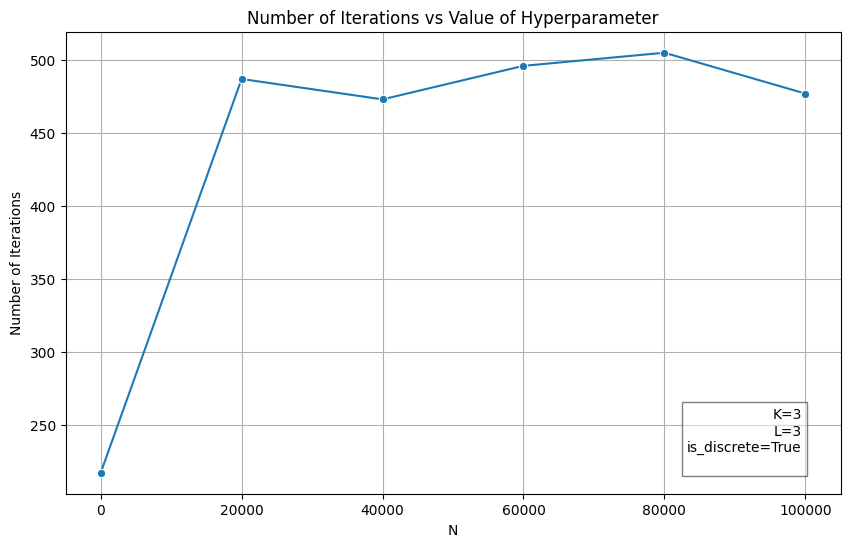

In [98]:
# Parameters setup
k_values = [3]
l_values = [3]
tuning_n_values = [10, 20000, 40000, 60000, 80000, 100000]
iterations = 10
lr=1

# Call the hyperparameter tuning function
varied_hyperparameter_results_n = hyperparameter_tuning(k_values, l_values, tuning_n_values, lr, iterations)
plot_iterations_vs_hyperparameter(tuning_n_values, varied_hyperparameter_results_n, x_label='N', is_discrete=True, K=k_values[0], L=l_values[0])

Average iterations for k=3, l=3, n=100: 351
Average iterations for k=3, l=6, n=100: 1584
Average iterations for k=3, l=9, n=100: 3336
Average iterations for k=3, l=12, n=100: 6444
Average iterations for k=3, l=15, n=100: 14860
Average iterations for k=3, l=18, n=100: 16681
Average iterations for k=3, l=21, n=100: 18850
Average iterations for k=3, l=24, n=100: 33879
Average iterations for k=3, l=27, n=100: 41984
Average iterations for k=3, l=30, n=100: 49357


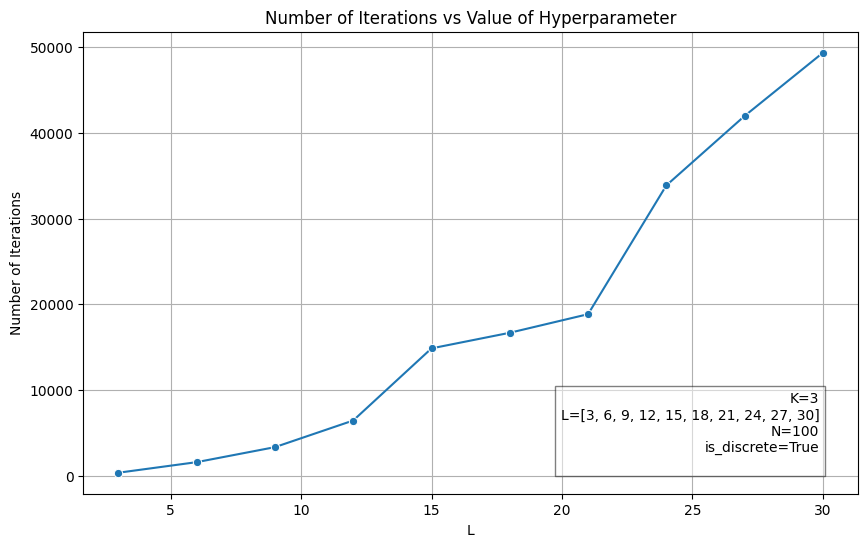

In [99]:
# Parameters setup
k_values = [3]
tuning_l_values = [i for i in range(3, 31) if i % 3 == 0]
n_values = [100]
iterations = 10
lr=1
is_discrete = True

# Call the hyperparameter tuning function
varied_hyperparameter_results_l = hyperparameter_tuning(k_values, tuning_l_values, n_values, lr, iterations, is_discrete)

plot_iterations_vs_hyperparameter(tuning_l_values, varied_hyperparameter_results_l, x_label='L', is_discrete=True, K=k_values[0], L=tuning_l_values, N=n_values[0])

Average iterations for k=3, l=3, n=100: 304
Average iterations for k=6, l=3, n=100: 2478
Average iterations for k=9, l=3, n=100: 10335
Average iterations for k=12, l=3, n=100: 12306
Average iterations for k=15, l=3, n=100: 19413
Average iterations for k=18, l=3, n=100: 20622
Average iterations for k=21, l=3, n=100: 24084
Average iterations for k=24, l=3, n=100: 27480
Average iterations for k=27, l=3, n=100: 28482
Average iterations for k=30, l=3, n=100: 34726


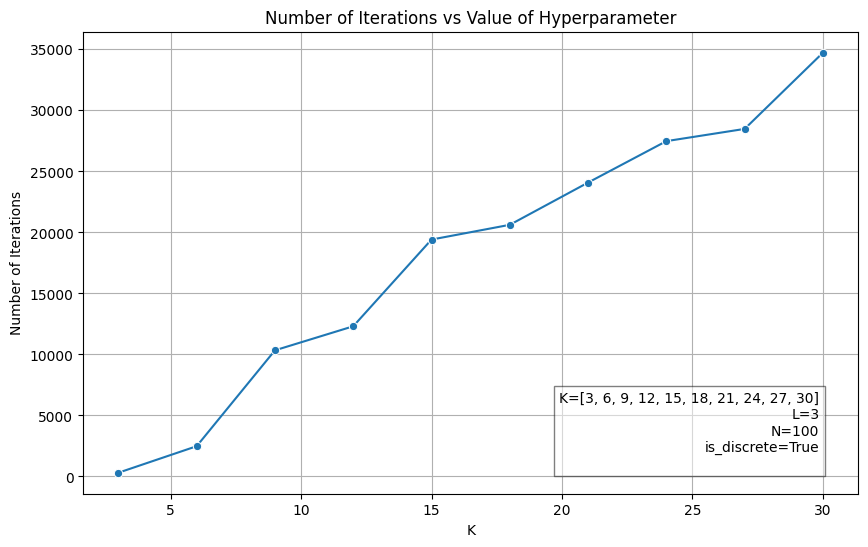

In [100]:
# Parameters setup
tuning_k_values = [i for i in range(3, 31) if i % 3 == 0]
l_values = [3]
n_values = [100]
iterations = 10
lr=1

# Call the hyperparameter tuning function
varied_hyperparameter_results_k = hyperparameter_tuning(tuning_k_values, l_values, n_values, lr, iterations)

plot_iterations_vs_hyperparameter(tuning_k_values, varied_hyperparameter_results_k, x_label='K', is_discrete=True, K=tuning_k_values, L=l_values[0], N=n_values[0])

## Testing protocol convergence with continuous weight

Average iterations for k=3, l=3, n=10: 214
Average iterations for k=3, l=3, n=20000: 511
Average iterations for k=3, l=3, n=40000: 486
Average iterations for k=3, l=3, n=60000: 483
Average iterations for k=3, l=3, n=80000: 428
Average iterations for k=3, l=3, n=100000: 504


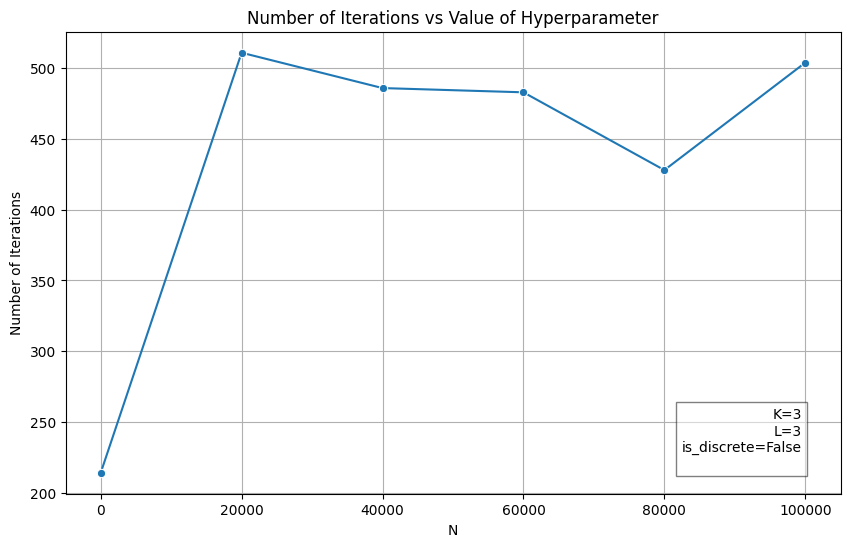

In [169]:
# Parameters setup
k_values = [3]
l_values = [3]
tuning_n_values = [10, 20000, 40000, 60000, 80000, 100000]
iterations = 10
lr=1
is_discrete = False
# Call the hyperparameter tuning function
varied_hyperparameter_results_n = hyperparameter_tuning(k_values, l_values, tuning_n_values, lr, iterations, is_discrete)
plot_iterations_vs_hyperparameter(tuning_n_values, varied_hyperparameter_results_n, x_label='N', is_discrete=False, K=k_values[0], L=l_values[0])

## Testing protocol convergence with learning rate

Average iterations for k=3, l=3, n=10: 532
Average iterations for k=3, l=3, n=20000: 1360
Average iterations for k=3, l=3, n=40000: 1402
Average iterations for k=3, l=3, n=60000: 1450
Average iterations for k=3, l=3, n=80000: 1442
Average iterations for k=3, l=3, n=100000: 1494


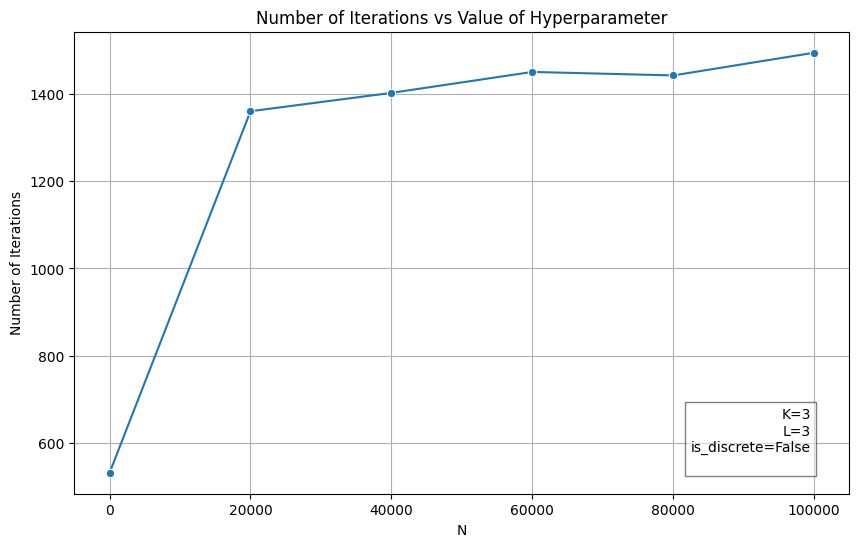

In [170]:
# Parameters setup
k_values = [3]
l_values = [3]
tuning_n_values = [10, 20000, 40000, 60000, 80000, 100000]
iterations = 10
lr=0.6
is_discrete = False
# Call the hyperparameter tuning function
varied_hyperparameter_results_n = hyperparameter_tuning(k_values, l_values, tuning_n_values, lr, iterations, is_discrete)
plot_iterations_vs_hyperparameter(tuning_n_values, varied_hyperparameter_results_n, x_label='N', is_discrete=False, K=k_values[0], L=l_values[0])

## How N impact the convergence at higher value of K

Average iterations for k=30, l=3, n=20: 4954
Average iterations for k=30, l=3, n=40: 15297
Average iterations for k=30, l=3, n=60: 21526
Average iterations for k=30, l=3, n=80: 24881
Average iterations for k=30, l=3, n=100: 30730


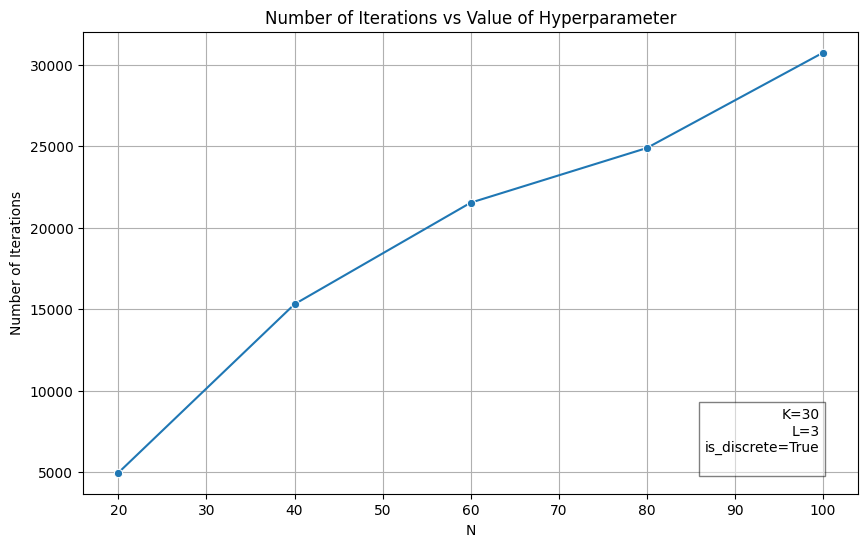

In [11]:
# Parameters setup
k_values = [30]
l_values = [3]
tuning_n_values = [20, 40, 60, 80, 100]
iterations = 5
lr=1
is_discrete = True

# # Call the hyperparameter tuning function
varied_hyperparameter_results_n = hyperparameter_tuning(k_values, l_values, tuning_n_values, lr, iterations, is_discrete)
plot_iterations_vs_hyperparameter(tuning_n_values, varied_hyperparameter_results_n, x_label='N', is_discrete=True, K=k_values[0], L=l_values[0])

# Attacks

In [24]:
ATTACK_TYPE = {
    1: 'SIMPLE_ATTACK',
    2: 'PASSIVE_ATTACK',
    3: 'GEOMETRIC_ATTACK'
}

In [18]:
def local_field_adjustment(tpm_attacker, tau, inputs, l):
    """Perform minimum local field adjustment on the attacker's TPM."""
    k = tpm_attacker.k
    min_field_value = np.inf
    min_index = None
    o_C = []  # List to store neuron's outputs

    # Step 1: Compute local fields and neuron outputs
    for i in range(k):
        local_field = np.sum(inputs[i] * tpm_attacker.weights[i])
        o_C_i = np.sign(local_field)
        if o_C_i == 0:
            o_C_i = 1  # Ensure no zero output
        o_C.append(o_C_i)

    # Step 2: Compute tau_attacker
    tau_attacker = np.prod(o_C)

    # Step 3: If outputs differ, attempt to flip a neuron's output
    for i in range(k):
        if o_C[i] != tau:
            local_field = np.sum(inputs[i] * tpm_attacker.weights[i])
            if abs(local_field) < min_field_value:
                min_field_value = abs(local_field)
                min_index = i

    # Flip the output of the neuron with minimal local field
    if min_index is not None:
        o_C[min_index] *= -1  # Flip the neuron's output

        # Recompute tau_attacker
        tau_attacker = np.prod(o_C)

        # Step 4: Update weights with modified outputs
        for i in range(tpm_attacker.k):
          if o_C[i] == tau:

            tpm_attacker.weights[i] += inputs[i] #tau *
            # Ensure weights are within [-L, L]
            tpm_attacker.weights[i] = np.clip(tpm_attacker.weights[i], -tpm_attacker.l, tpm_attacker.l)

In [19]:
# Geometric attack
def key_exchange_attack(k, n, l, is_discrete, lr=1, limit=20, ATTACK_TYPE = 1, max_iter = 100000):
      tpm_A = TreeParityMachine(k, n, l, lr)
      tpm_B = TreeParityMachine(k, n, l, lr)
      tpm_attacker = TreeParityMachine(k, n, l, lr)

      consecutive_same_output = 0
      iteration = 0
      while consecutive_same_output < limit and iteration < max_iter:

          iteration += 1
          inputs = np.random.choice([-1, 1], size=(k, n))

          tau_A = tpm_A.compute_output(inputs)
          tau_B = tpm_B.compute_output(inputs)
          tau_attacker = tpm_attacker.compute_output(inputs)

          if tau_A == tau_B:
              consecutive_same_output += 1
              tpm_A.update_weights(inputs, tau_B, lr)
              tpm_B.update_weights(inputs, tau_A, lr)
              if tau_A == tau_attacker:
                    tpm_attacker.update_weights(inputs, tau_A, lr)

              if ATTACK_TYPE == 2:
                  if tau_A != tau_attacker:
                    tpm_attacker.update_weights(inputs, tau_A, lr)

              elif ATTACK_TYPE == 3:
                if tau_A != tau_attacker:
                  local_field_adjustment(tpm_attacker, tau_A, inputs, l)

          else:
              consecutive_same_output = 0 # Reset counter if outputs do not match
              continue

          if consecutive_same_output > limit:
              alice_bob_sync = np.array_equal(tpm_A.get_weights(), tpm_B.get_weights())
              attacker_sync = np.array_equal(tpm_A.get_weights(), tpm_attacker.get_weights())

              # Calculate Hamming distances
              hamming_distance_attacker = hamming(tpm_A.get_weights().flatten(), tpm_attacker.get_weights().flatten()) * len(tpm_A.get_weights().flatten())

              print(f"Iteration {iteration}: Hamming distance between Alice and Attacker: {hamming_distance_attacker}")

              return tpm_A.get_weights(), iteration + 1, alice_bob_sync, attacker_sync


      alice_bob_sync = np.array_equal(tpm_A.get_weights(), tpm_B.get_weights())
      attacker_sync = np.array_equal(tpm_A.get_weights(), tpm_attacker.get_weights())

      # Calculate Hamming distances
      hamming_distance_attacker = hamming(tpm_A.get_weights().flatten(), tpm_attacker.get_weights().flatten()) * len(tpm_A.get_weights().flatten())

      print(f"Iteration {iteration}: Hamming distance between Alice and Attacker: {hamming_distance_attacker}")

      return tpm_A.get_weights(), iteration + 1, alice_bob_sync, attacker_sync



# Delete
k = 3
n = 101
l = 3
limit = 200
ATTACK_TYPE = 2
max_iter = 100000
is_discrete = True
lr = 1

print('total bits: ' + str(k*n))
key_exchange_attack(k, n, l, is_discrete, lr, limit, ATTACK_TYPE, max_iter)

total bits: 303
Iteration 377: Hamming distance between Alice and Attacker: 157.00000000000003


(array([[ 2,  1, -3,  1,  0,  3, -1,  2, -1, -1, -3, -1, -1, -2, -1,  1,
         -1, -2, -2, -2,  2,  1, -1, -3, -1,  2,  3, -2, -3,  2,  1,  2,
          3,  0, -2, -3,  2,  1,  3, -1,  0,  2, -3,  3, -2,  3, -2,  3,
         -1,  2,  3,  1, -2,  1, -2, -1,  1,  0,  0,  2,  3,  0, -2, -1,
         -3,  3, -2,  0, -1, -3,  0, -3,  3,  3,  3,  3,  2, -1,  0,  2,
          1,  3,  3,  3,  0,  1,  1, -3,  3,  2,  1,  3,  3, -2,  3,  0,
         -2, -3, -1,  0,  3],
        [ 1,  2,  2,  2,  0, -2, -2,  2, -3, -1, -1, -2, -2,  1,  0, -2,
          2, -1,  2,  0, -1,  3, -1, -3,  1,  3,  3,  0,  3,  3,  1,  1,
          3,  3, -1, -2,  0,  0,  0,  3,  3, -3,  0,  1, -3,  3,  1, -2,
          2,  3,  0, -1,  2, -2,  1, -1, -3,  2,  3,  2,  1, -3,  0,  0,
          3,  2,  2,  1, -3,  1, -1, -2, -1,  2, -2, -1,  2,  0,  0, -3,
          0,  1,  0, -2,  2,  2, -3,  0, -2,  2, -1,  3,  3,  1,  2, -2,
         -1,  2, -2,  1, -1],
        [-3, -1, -2, -2,  0,  0,  2,  0,  2,  3,  3,  3, -3, -3,

In [147]:
def protocol_probability(k=3, n=10, l=3, is_discrete=True, max_iter=10000, limit=200, sample_size=100, ATTACK_TYPE=1):
    count = 0
    success_count = 0

    for i in range(sample_size):
        _, _, is_sync, is_success = key_exchange_attack(k, n, l, is_discrete, lr, limit, ATTACK_TYPE)

        if is_sync:
            count += 1
            if is_success:
                success_count += 1

    success_percentage = 0
    success_attacks_percentage = 0

    if count == 0:
        print('Alice and Bob did not sync even once. Try increasing the limit.')
    else:
        success_percentage = float(count / sample_size) * 100
        success_attacks_percentage = float(success_count / count) * 100

    print(f'success_percentage = {success_percentage}')
    print(f'success_attacks_percentage = {success_attacks_percentage}')

    return success_percentage, success_attacks_percentage



###This test case shows that protocol could be broken at the value of K=3, N=101, L=3

In [150]:
protocol_probability(k=3, n=101, l=3, is_discrete=True, max_iter=10000, limit=200, sample_size=100, ATTACK_TYPE=3)

Iteration 529: Hamming distance between Alice and Attacker: 234.99999999999997
Iteration 480: Hamming distance between Alice and Attacker: 184.99999999999997
Iteration 469: Hamming distance between Alice and Attacker: 186.0
Iteration 608: Hamming distance between Alice and Attacker: 218.0
Iteration 448: Hamming distance between Alice and Attacker: 161.0
Iteration 582: Hamming distance between Alice and Attacker: 134.0
Iteration 441: Hamming distance between Alice and Attacker: 220.0
Iteration 587: Hamming distance between Alice and Attacker: 216.0
Iteration 468: Hamming distance between Alice and Attacker: 201.0
Iteration 563: Hamming distance between Alice and Attacker: 216.0
Iteration 532: Hamming distance between Alice and Attacker: 195.99999999999997
Iteration 480: Hamming distance between Alice and Attacker: 115.0
Iteration 736: Hamming distance between Alice and Attacker: 227.0
Iteration 562: Hamming distance between Alice and Attacker: 208.0
Iteration 548: Hamming distance betwe

(100.0, 1.0)

In [25]:
def multiple_attack_scenario(k_list=[1], n_list=[10], l_list=[1], is_discrete=True, max_iter=100000,  limit_list=[30], sample_size=100, ATTACK_TYPE=[1]):
    success_percentage_list = []
    success_attacks_list = []
    k_final_list = []
    l_final_list = []
    n_final_list = []
    attack_list = []
    limit_final_list = []

    for k in k_list:
        for l in l_list:
            for n in n_list:
                for limit in limit_list:
                    for attack in ATTACK_TYPE:
                        success_percentage, success_attacks = protocol_probability(
                            k, n, l, is_discrete, max_iter, limit, sample_size, ATTACK_TYPE=attack)
                        k_final_list.append(k)
                        l_final_list.append(l)
                        n_final_list.append(n)
                        success_attacks_list.append(success_attacks)
                        success_percentage_list.append(success_percentage)
                        attack_list.append(attack)
                        limit_final_list.append(limit)

            # print(f'''For values:
            #           k = {k},
            #           n = {n},
            #           l = {l},
            #           limit = {limit},
            #           success_attacks = {success_attacks},
            #           success_percentage = {success_percentage},
            #           attack_type = {attack}
            #           '''
            #       )
    return k_final_list, l_final_list, n_final_list, limit_final_list, success_percentage_list, success_attacks_list, attack_list


def create_success_metrics_dataframe(k_vals, n_vals, l_vals, limit_vals, attack_vals, success_perc, success_attacks_perc):
    data = pd.DataFrame({
        'K': k_vals,
        'N': n_vals,
        'L': l_vals,
        'Limit': limit_vals,
        'Attack': attack_vals,
        'Success_Percentage': success_perc,
        'Success_Attacks_Percentage': success_attacks_perc
    })
    return data


def plot_success_attack_percentage(data, n_value, k_value):
    unique_ks = data['K'].unique()  # Get unique values of K
    unique_limits = data['Limit'].unique()  # Get unique values of Limit

    for k_value in unique_ks:  # Iterate over unique K values
        for limit in unique_limits:  # Iterate over unique limit values
            subset = data[(data['K'] == k_value) & (data['Limit'] == limit)]  # Filter data by K and Limit
            plt.figure(figsize=(10, 6))

            # Add the text box with the attack mapping
            attack_mapping_text = '\n'.join([f'{key}: {value}' for key, value in ATTACK_TYPE.items()])
            plt.figtext(0.5, 0.96, attack_mapping_text, wrap=True, horizontalalignment='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5))

            sns.lineplot(data=subset, x='L', y='Success_Attacks_Percentage', hue='Attack',
                         style='Attack', markers=True, palette='Set1')  # Using a distinct color palette
            plt.title(f'Success Attack Percentage vs L (K = {k_value}, Limit = {limit})')
            plt.xlabel('L')
            plt.ylabel('Success Attack Percentage')
            plt.ylim(0, 105)
            plt.legend(title='Attack Type')
            plt.grid(True)

            plt.show()


def plot_success_convergence_percentage(data, n_value, k_value):
    unique_ks = data['K'].unique()  # Get unique values of K
    unique_limits = data['Limit'].unique()  # Get unique values of Limit

    for k_value in unique_ks:  # Iterate over unique K values
        for limit in unique_limits:  # Iterate over unique limit values
            subset = data[(data['K'] == k_value) & (data['Limit'] == limit)]  # Filter data by K and Limit
            plt.figure(figsize=(10, 6))

            # Add the text box with the attack mapping
            attack_mapping_text = '\n'.join([f'{key}: {value}' for key, value in ATTACK_TYPE.items()])
            plt.figtext(0.5, 0.96, attack_mapping_text, wrap=True, horizontalalignment='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5))

            sns.lineplot(data=subset, x='L', y='Success_Percentage', hue='Attack', style='Attack', markers=True, palette='Set1')
            plt.title(f'Success Convergence Percentage vs L (K = {k_value}, Limit = {limit})')
            plt.xlabel('L')
            plt.ylabel('Success Convergence Percentage')
            plt.ylim(0, 105)
            plt.legend(title='Attack Type')
            plt.grid(True)

            plt.show()


In [30]:
# Example usage:
k_list = [1, 2, 3]
n_list = [10]
l_list = [i for i in range(1, 6)]
attacks = [1, 2, 3]
is_discrete = [True]
max_iter = 60000
limit = [30, 200]
sample_size = 100

# Assuming multiple_attack_scenario returns the required data
k_vals, n_vals, l_vals, limit_vals, success_perc, success_attacks_perc, attack_vals = multiple_attack_scenario(
    k_list, n_list, l_list, True, max_iter, limit, sample_size, attacks
)


Streaming output truncated to the last 5000 lines.
Iteration 231: Hamming distance between Alice and Attacker: 0.0
Iteration 238: Hamming distance between Alice and Attacker: 0.0
Iteration 202: Hamming distance between Alice and Attacker: 8.0
Iteration 283: Hamming distance between Alice and Attacker: 0.0
Iteration 221: Hamming distance between Alice and Attacker: 0.0
Iteration 265: Hamming distance between Alice and Attacker: 0.0
Iteration 269: Hamming distance between Alice and Attacker: 3.0
Iteration 235: Hamming distance between Alice and Attacker: 0.0
Iteration 270: Hamming distance between Alice and Attacker: 0.0
Iteration 232: Hamming distance between Alice and Attacker: 0.0
Iteration 234: Hamming distance between Alice and Attacker: 0.0
Iteration 240: Hamming distance between Alice and Attacker: 3.0
Iteration 210: Hamming distance between Alice and Attacker: 0.0
Iteration 309: Hamming distance between Alice and Attacker: 0.0
Iteration 233: Hamming distance between Alice and Att

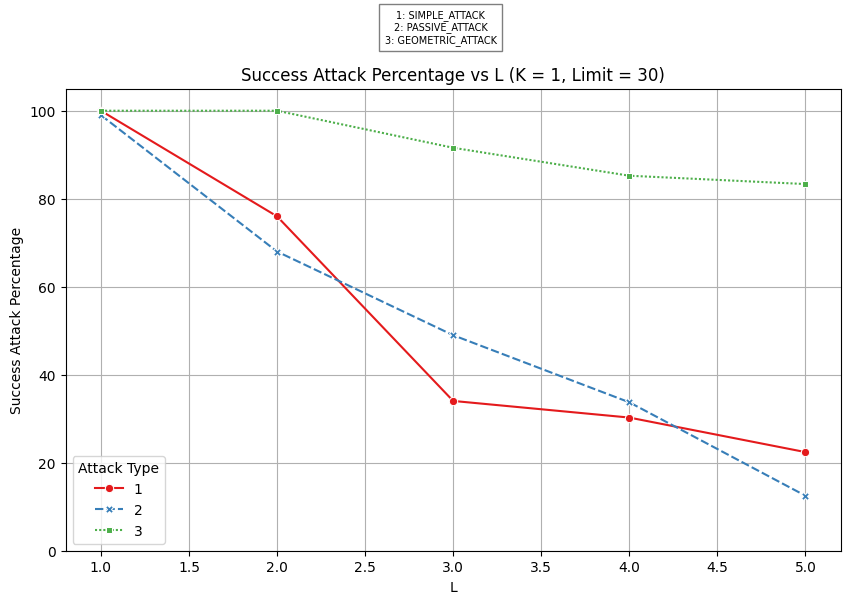

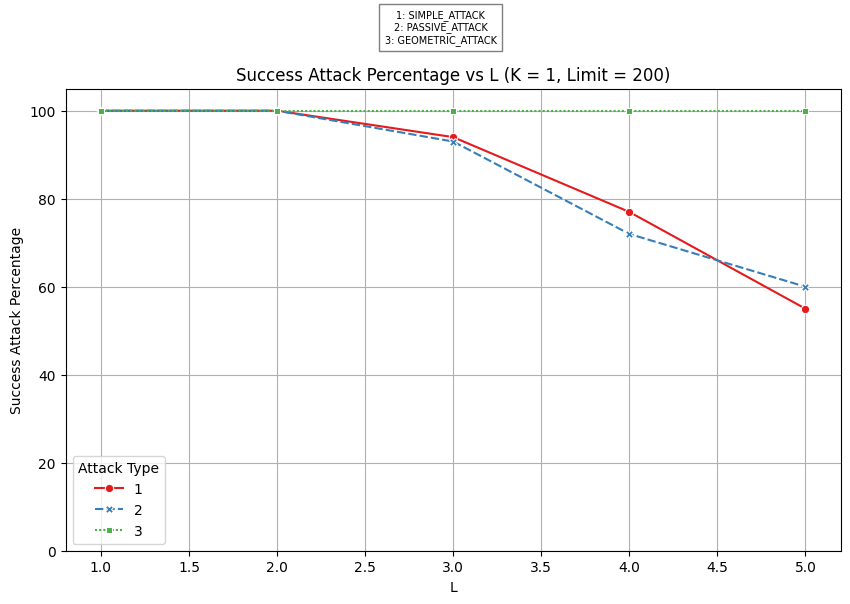

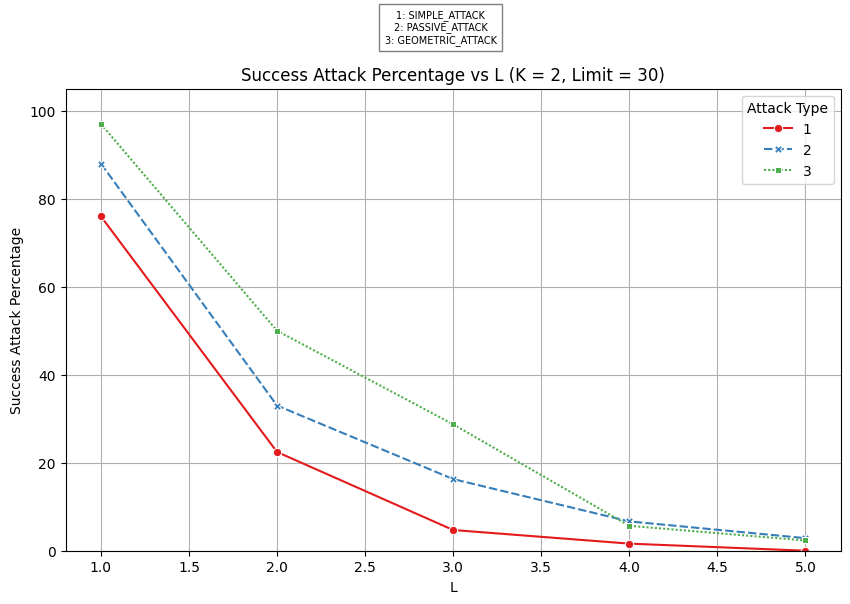

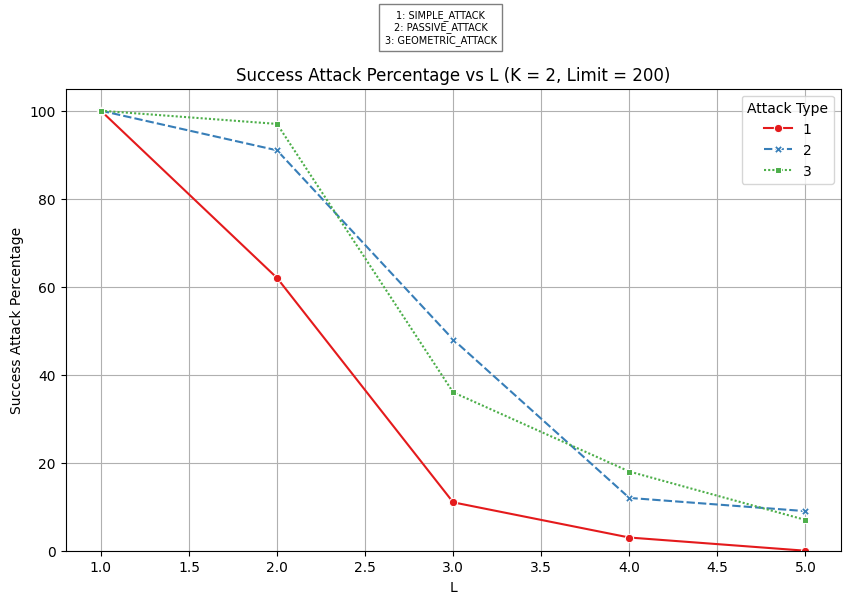

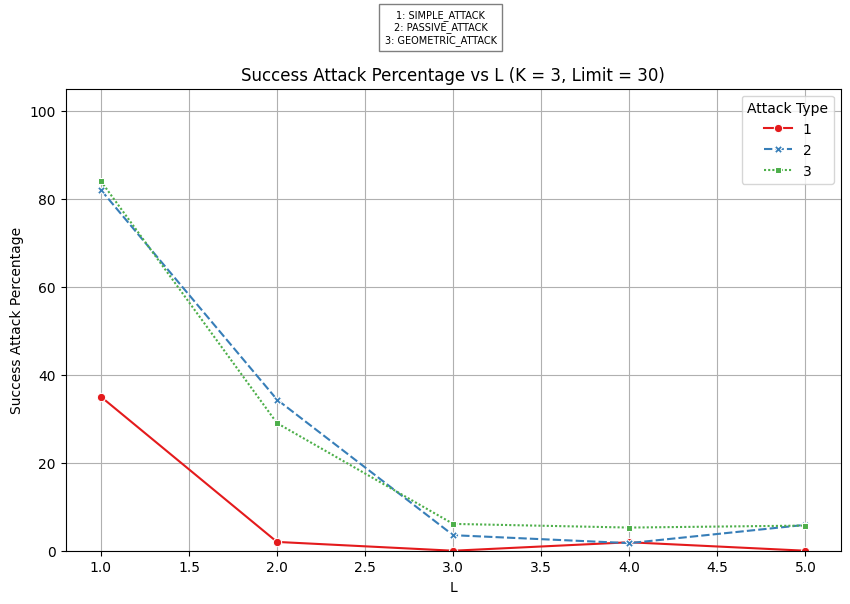

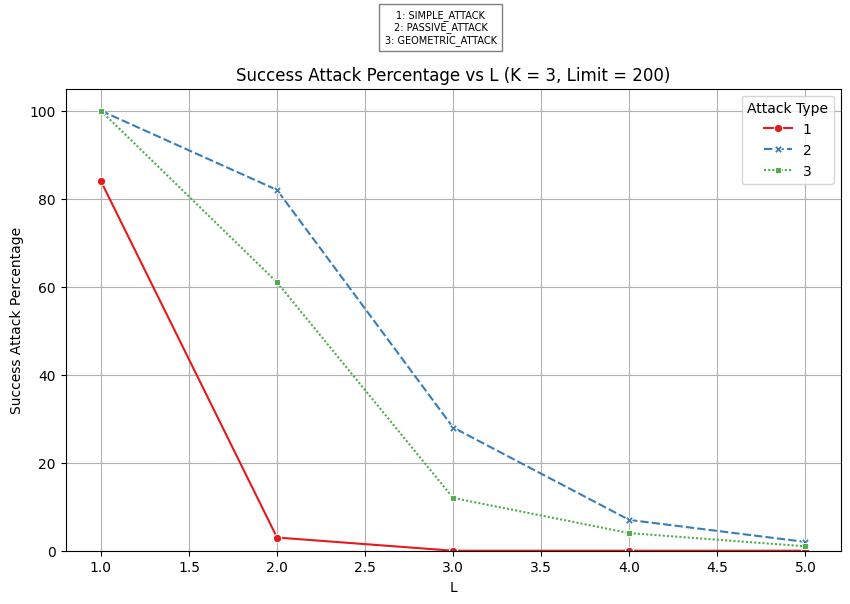

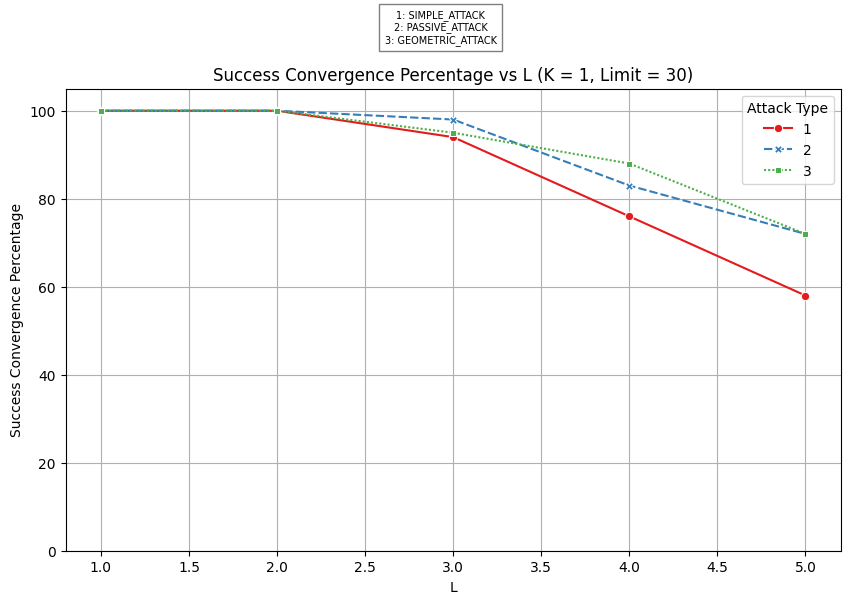

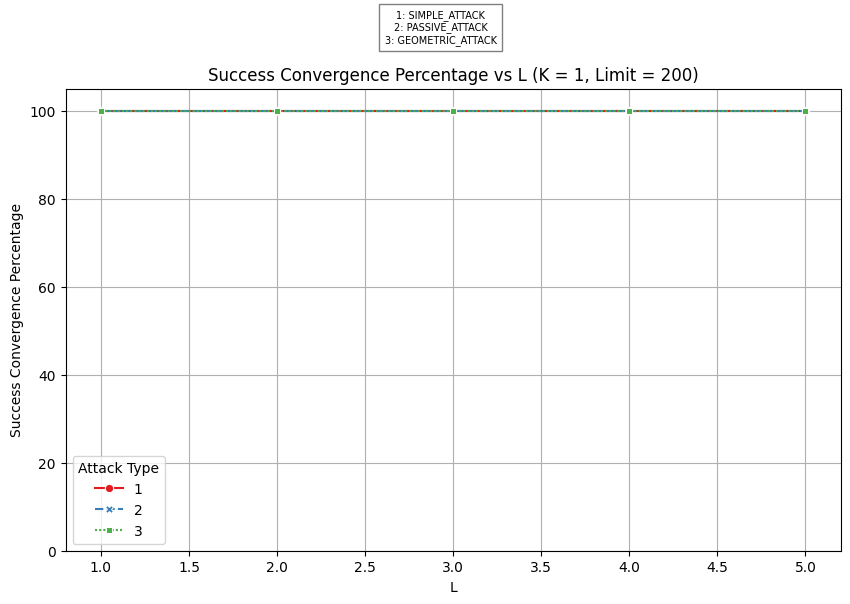

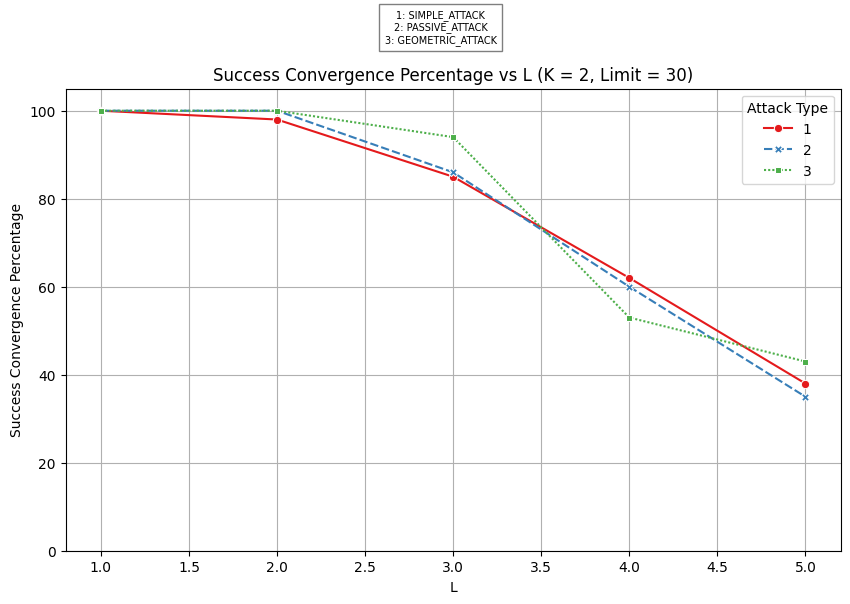

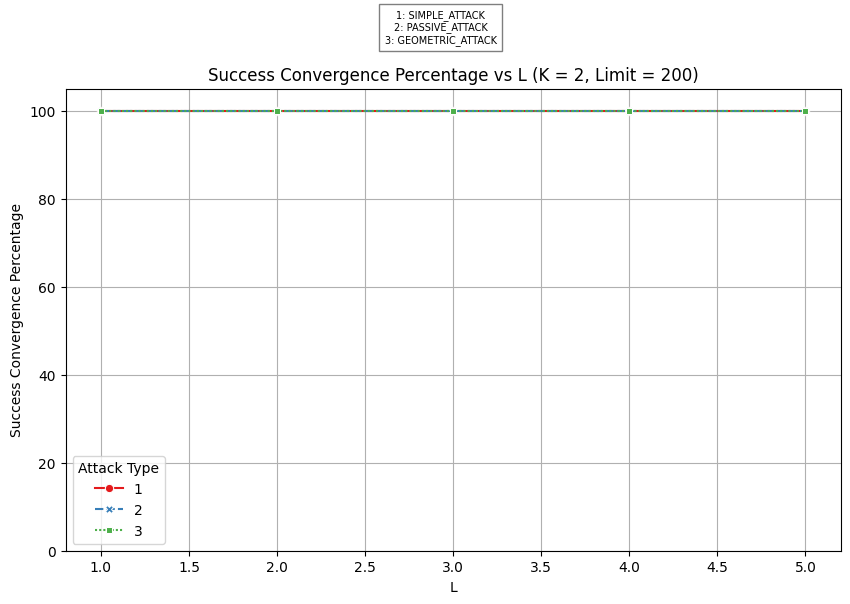

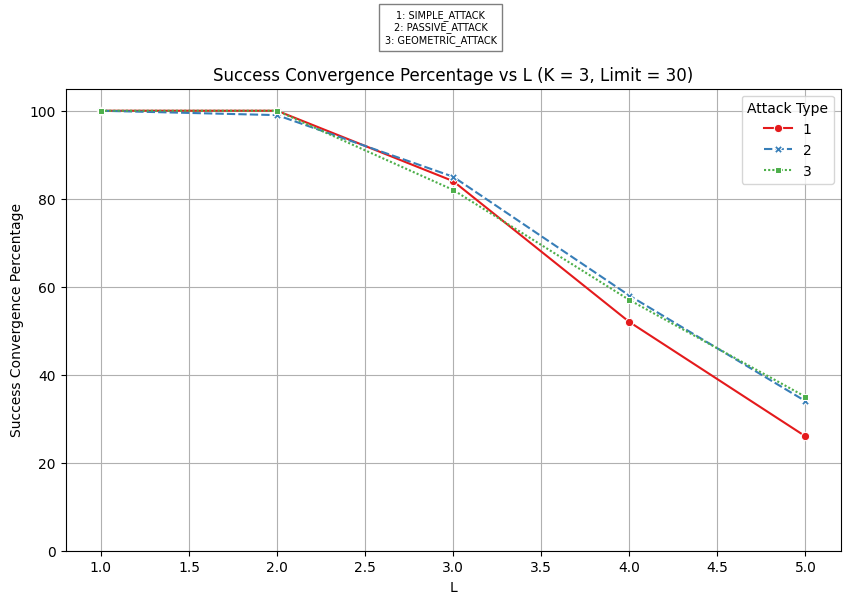

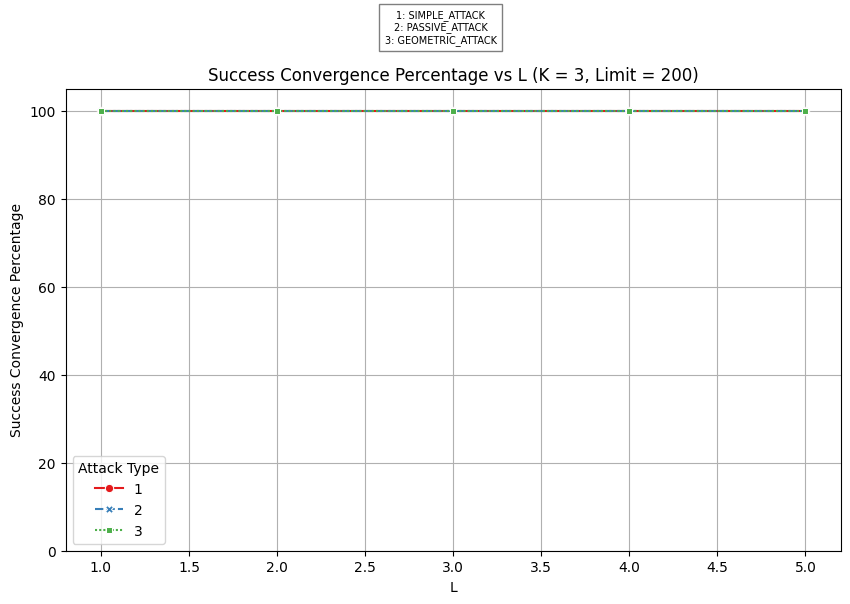

In [31]:
# Create DataFrame
data = create_success_metrics_dataframe(k_vals, l_vals, n_vals, limit_vals, attack_vals, success_perc, success_attacks_perc)

# Plot Success Attack Percentage
plot_success_attack_percentage(data, n_list[0], k_list)

# Plot Success Convergence Percentage
plot_success_convergence_percentage(data, n_list[0], k_list)

Different attack strategy where the attacker uses 7 machines in parallel.

In [93]:
import numpy as np

def key_exchange_attack_variant(k, n, l, is_discrete=True, max_iter=1000000, limit=20):
      # Initialize TPMs for Alice, Bob, and attackers
      tpm_A = TreeParityMachine(k, n, l, is_discrete)
      tpm_B = TreeParityMachine(k, n, l, is_discrete)

      tpm_attacker_11 = TreeParityMachine(k, n, l, is_discrete)  # Eve's TPM 1
      tpm_attacker_12 = TreeParityMachine(k, n, l, is_discrete)  # Eve's TPM 2 (with different strategy)
      tpm_attacker_21 = TreeParityMachine(k, n, l, is_discrete)  # Eve's TPM 3
      tpm_attacker_22 = TreeParityMachine(k, n, l, is_discrete)  # Eve's TPM 4 (with different strategy)
      tpm_attacker_31 = TreeParityMachine(k, n, l, is_discrete)   # Eve's TPM 5 (sync with both Alice and Bob)
      tpm_attacker_32 = TreeParityMachine(k, n, l, is_discrete)   # Eve's TPM 6 (with different strategy)
      tpm_attacker_33 = TreeParityMachine(k, n, l, is_discrete)  # Eve's TPM 7 (with different strategy)

      consecutive_same_output = 0
      attacker_sync_before_bob = False

      for iteration in range(max_iter):
          inputs = np.random.choice([-1, 1], size=(k, n))

          # Compute outputs for Alice, Bob, and attackers
          output_A = tpm_A.compute_output(inputs)
          output_B = tpm_B.compute_output(inputs)

          output_attacker_11 = tpm_attacker_11.compute_output(inputs)
          output_attacker_12 = tpm_attacker_12.compute_output(inputs)
          output_attacker_21 = tpm_attacker_21.compute_output(inputs)
          output_attacker_22 = tpm_attacker_22.compute_output(inputs)
          output_attacker_31 = tpm_attacker_31.compute_output(inputs)
          output_attacker_32 = tpm_attacker_32.compute_output(inputs)
          output_attacker_33 = tpm_attacker_33.compute_output(inputs)

          # Synchronize Alice and Bob
          if output_A == output_B:
              consecutive_same_output += 1
              tpm_A.update_weights(inputs, output_A)
              tpm_B.update_weights(inputs, output_B)

              if output_A == output_attacker_31:
                  tpm_attacker_31.update_weights(inputs, output_attacker_31)

              if output_A == output_attacker_32:
                  tpm_attacker_32.update_weights(inputs, output_attacker_32)
              else:
                  local_field_adjustment(tpm_attacker_32, output_A, inputs, l)


              tpm_attacker_33.update_weights(inputs, output_attacker_33)




          else:
              consecutive_same_output = 0  # Reset if Alice and Bob's outputs don't match


          # Update attacker TPMs and check if they sync before Bob
          if output_A == output_attacker_11:
              tpm_attacker_11.update_weights(inputs, output_attacker_11)
              if np.array_equal(tpm_A.get_weights(), tpm_attacker_11.get_weights()) and not np.array_equal(tpm_A.get_weights(), tpm_B.get_weights()):
                  attacker_sync_before_bob = True

          if output_A == output_attacker_12:
              tpm_attacker_12.update_weights(inputs, output_attacker_12)
              if np.array_equal(tpm_A.get_weights(), tpm_attacker_12.get_weights()) and not np.array_equal(tpm_A.get_weights(), tpm_B.get_weights()):
                  attacker_sync_before_bob = True
          else:
              local_field_adjustment(tpm_attacker_12, output_A, inputs, l)

          if output_B == output_attacker_21:
              tpm_attacker_21.update_weights(inputs, output_attacker_21)
              if np.array_equal(tpm_B.get_weights(), tpm_attacker_21.get_weights()) and not np.array_equal(tpm_A.get_weights(), tpm_B.get_weights()):
                  attacker_sync_before_bob = True

          if output_B == output_attacker_22:
              tpm_attacker_22.update_weights(inputs, output_attacker_22)
              if np.array_equal(tpm_B.get_weights(), tpm_attacker_22.get_weights()) and not np.array_equal(tpm_A.get_weights(), tpm_B.get_weights()):
                  attacker_sync_before_bob = True
          else:
              local_field_adjustment(tpm_attacker_22, output_A, inputs, l)

          # Check synchronization
          if consecutive_same_output > limit:
              alice_bob_sync = np.array_equal(tpm_A.get_weights(), tpm_B.get_weights())
              attacker_sync = (
                  np.array_equal(tpm_A.get_weights(), tpm_attacker_11.get_weights()) or
                  np.array_equal(tpm_A.get_weights(), tpm_attacker_12.get_weights()) or
                  np.array_equal(tpm_B.get_weights(), tpm_attacker_21.get_weights()) or
                  np.array_equal(tpm_B.get_weights(), tpm_attacker_22.get_weights()) or
                  np.array_equal(tpm_A.get_weights(), tpm_attacker_31.get_weights()) or
                  np.array_equal(tpm_A.get_weights(), tpm_attacker_32.get_weights()) or
                  np.array_equal(tpm_A.get_weights(), tpm_attacker_33.get_weights())
              )

              return tpm_A.get_weights(), iteration + 1, alice_bob_sync, attacker_sync_before_bob, attacker_sync

      return None, None, False, False, False


In [144]:
# geometric attack:
def calculating_probability_of_hybrid_attacks(k=1, n=10, l=1, is_discrete=True, max_iter=5000, limit=200, sample_size=100):
  count = 0
  success_count = 0
  avg_iterations = 0
  for i in range(sample_size):
    _, iteration, is_sync, sync_before, is_success = key_exchange_attack_variant(k, n, l, True, max_iter, limit)
    avg_iterations += iteration
    # if ( i + 1 ) % 1000 == 0:
    #   print('Number of iteration done: ' + str(i + 1))

    if is_sync:
      count += 1
      if sync_before or is_success:
        print('Successful Attack')

        success_count += 1

  if count == 0:
    return float(0), float(0)

  avg_iterations = avg_iterations / sample_size
  print(avg_iterations)
  return float((count/sample_size) * 100), float((success_count/count) * 100)

# calculating_probability_of_hybrid_attacks(k=6, n=8, l=7, is_discrete=True, max_iter=100000, limit=200, sample_size=10)

### This show that protocol shows a convergence rate of nearly 100% when limit is 200 and successful attacks are zero for 1000 **simulation**

In [145]:
calculating_probability_of_hybrid_attacks(k=6, n=8, l=7, is_discrete=True, max_iter=100000, limit=200, sample_size=1000)

3616.009


(99.9, 0.0)

In [97]:
def try_hybrid_attack_combinations(k_values, n_values, l_values, is_discrete_values, limit_values, max_iter=20000, sample_size=100):
    results = []

    for k in k_values:
        for n in n_values:
            for l in l_values:
                for is_discrete in is_discrete_values:
                    for limit in limit_values:

                        # Call the function with the current combination of parameters
                        convergence, success_prob = calculating_probability_of_hybrid_attacks(
                            k=k, n=n, l=l, is_discrete=is_discrete,
                            max_iter=max_iter, limit=limit, sample_size=sample_size
                        )

                        # Store the result along with the parameters used
                        results.append({
                            'k': k,
                            'n': n,
                            'l': l,
                            'is_discrete': is_discrete,
                            'limit': limit,
                            'success_probability': success_prob,
                            'convergence': convergence
                        })



    return results

Stimulating attacks based on current strategy

In [98]:
k_values = [1, 2, 3]
n_values = [10]
l_values = [i for i in range(1, 6)]
is_discrete_values = [True]
limit_values = [200]
max_iter = 10000
sample_size = 100

results = try_hybrid_attack_combinations(
    k_values=k_values,
    n_values=n_values,
    l_values=l_values,
    is_discrete_values=is_discrete_values,
    limit_values=limit_values
)


In [99]:
results_df = pd.DataFrame(results)
results_df

,k,n,l,is_discrete,limit,success_probability,convergence
0,1,10,1,True,200,100.0,100.0
1,1,10,2,True,200,100.0,100.0
2,1,10,3,True,200,100.0,100.0
3,1,10,4,True,200,100.0,100.0
4,1,10,5,True,200,100.0,100.0
5,2,10,1,True,200,100.0,100.0
6,2,10,2,True,200,99.0,100.0
7,2,10,3,True,200,70.0,100.0
8,2,10,4,True,200,29.0,100.0
9,2,10,5,True,200,10.0,100.0


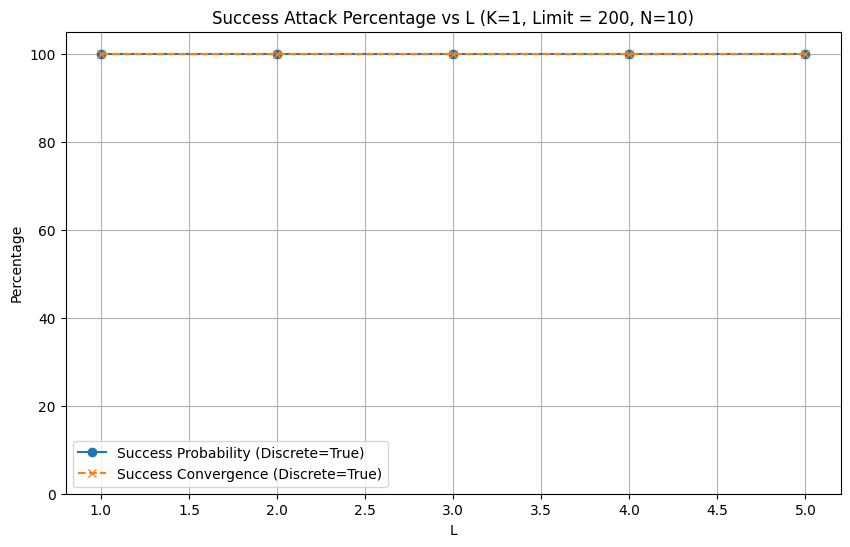

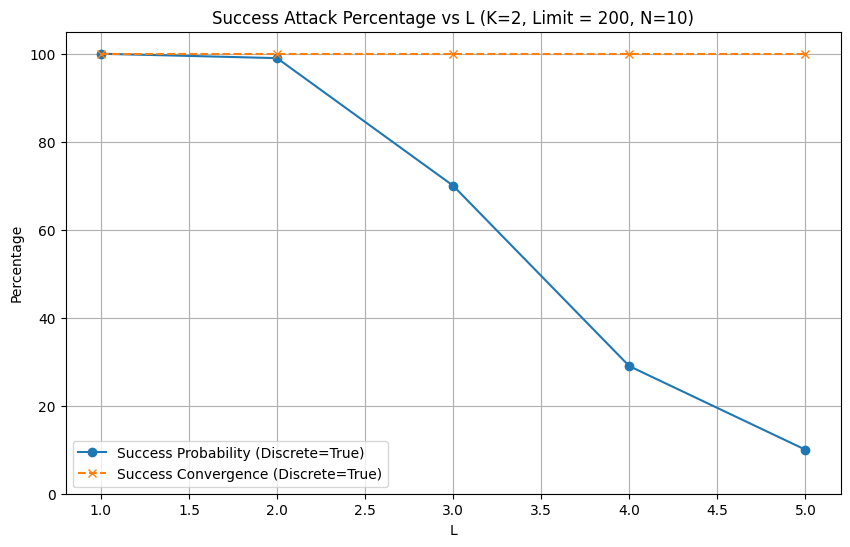

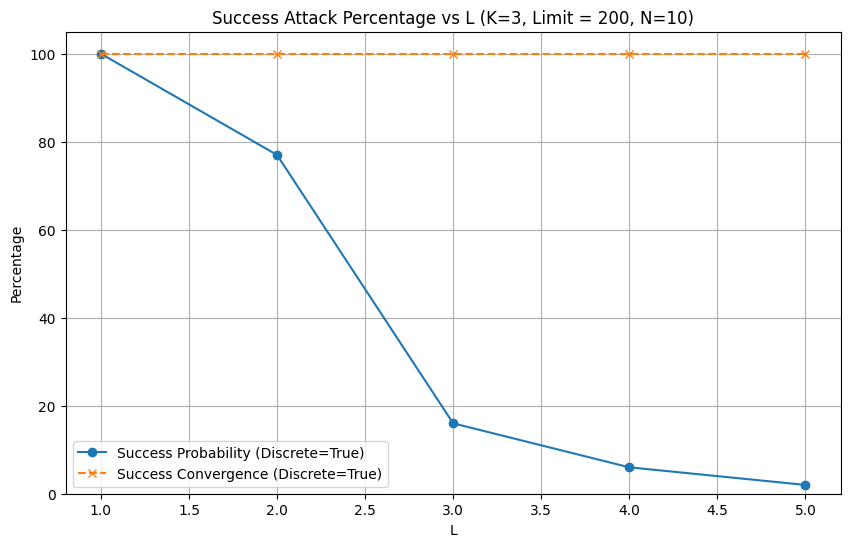

In [100]:
def plot_success_attack_percentage_all_k(data, n_value):
    unique_k_values = data['k'].unique()
    unique_limits = data['limit'].unique()
    unique_is_discrete = data['is_discrete'].unique()

    for k_value in unique_k_values:
        for limit in unique_limits:
            plt.figure(figsize=(10, 6))
            plt.title(f'Success Attack Percentage vs L (K={k_value}, Limit = {limit}, N={n_value})')
            plt.xlabel('L')
            plt.ylabel('Percentage')
            plt.ylim(0, 105)
            plt.grid(True)

            for is_discrete in unique_is_discrete:
                subset = data[(data['limit'] == limit) & (data['is_discrete'] == is_discrete) & (data['k'] == k_value)]
                l_values = subset['l']
                success_prob = subset['success_probability']
                success_convergence = subset['convergence']

                # Plot success probability
                plt.plot(l_values, success_prob, marker='o', linestyle='-', label=f'Success Probability (Discrete={is_discrete})')

                # Plot success convergence
                plt.plot(l_values, success_convergence, marker='x', linestyle='--', label=f'Success Convergence (Discrete={is_discrete})')

            plt.legend()
            plt.show()

# Example usage with the given parameters
plot_success_attack_percentage_all_k(results_df, n_value=10)


### How value of N affects attacks

In [89]:
k_values = [1, 2, 3]
n_values = [i for i in range(4, 101) if i % 4 == 0]
l_values = [3]
is_discrete_values = [True]
limit_values = [200]
max_iter = 100000
sample_size = 100


n_value_testing = try_hybrid_attack_combinations(
    k_values,
    n_values,
    l_values,
    is_discrete_values,
    limit_values,
    max_iter,
    sample_size,
)


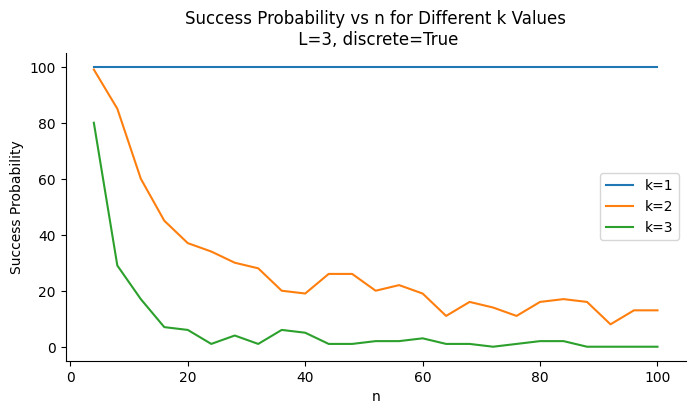

In [91]:
results_testing_df = pd.DataFrame(n_value_testing)

# Create a figure and axis for plotting
plt.figure(figsize=(8, 4))

# Loop through each value of k
for k in k_values:
    # Filter the DataFrame for the current value of k
    filtered_df = results_testing_df[results_testing_df['k'] == k]

    # Plot the data (color will be automatically assigned)
    plt.plot(filtered_df['n'], filtered_df['success_probability'], label=f'k={k}')

# Add a title and labels
plt.title('Success Probability vs n for Different k Values\n L=3, discrete=True')
plt.xlabel('n')
plt.ylabel('Success Probability')

# Remove the top and right spines from the plot
plt.gca().spines[['top', 'right']].set_visible(False)

# Add a legend to differentiate between the different values of k
plt.legend()

# Show the plot
plt.show()

Affect of limit on synchronization

In [112]:
k_values = [3]
n_values = [10]
l_values = [3]
is_discrete_values = [True]
limit_values = [20, 30, 50, 100, 1000, 10000, 15000]
max_iter = 30000
sample_size = 100

success_probability_based_on_limit = try_hybrid_attack_combinations(
    k_values,
    n_values,
    l_values,
    is_discrete_values,
    limit_values,
    max_iter,
    sample_size,

)

In [113]:
success_probability_testing = pd.DataFrame(success_probability_based_on_limit)
success_probability_testing

,k,n,l,is_discrete,limit,success_probability,convergence
0,3,10,3,True,20,13.559322,59.0
1,3,10,3,True,30,12.195122,82.0
2,3,10,3,True,50,8.163265,98.0
3,3,10,3,True,100,19.000000,100.0
4,3,10,3,True,1000,47.000000,100.0
5,3,10,3,True,10000,94.000000,100.0
6,3,10,3,True,15000,99.000000,100.0


In [114]:
df_success_probability = success_probability_testing[['success_probability', 'limit', 'k', 'n', 'l']]

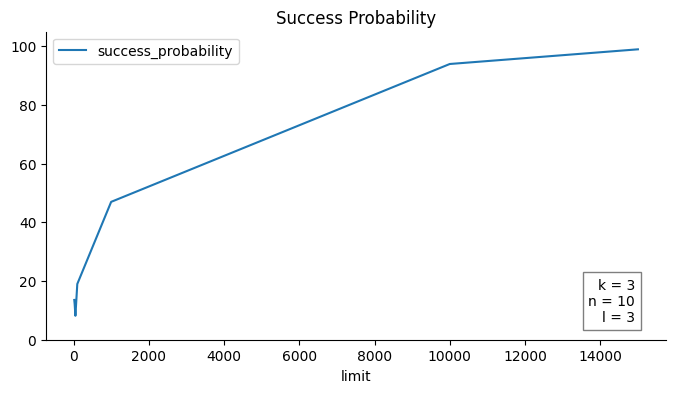

In [115]:
# Plotting the data
df_success_probability.plot(x='limit', y='success_probability', kind='line', figsize=(8, 4), title='Success Probability')

# Remove the top and right spines for a cleaner look
plt.gca().spines[['top', 'right']].set_visible(False)

textstr = f'k = {df_success_probability["k"][0]}\nn = {df_success_probability["n"][0]}\nl = {df_success_probability["l"][0]}'
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

plt.ylim(0, 105)

# Display the plot
plt.show()

# New Varient of attack: Geometric Attack++

In [70]:
def geometric_attack_plus_plus(k, n, l, number_of_machines, iterations, limit):
    tpm_1 = TreeParityMachine(k=k, n=n, l=l)
    tpm_2 = TreeParityMachine(k=k, n=n, l=l)
    attack_successful = False
    alice_bob_sync = False

    tpm_attackers = []
    initialization_points = tpm_1.point_initialization(number_of_machines)

    for i in range(number_of_machines):
        tpm_attacker_i = TreeParityMachine(k=k, n=n, l=l)  # Create TPM
        tpm_attacker_i.weights = initialization_points[i]  # Assign a unique initialization point to each attacker
        tpm_attackers.append(tpm_attacker_i)  # Add to the list of attackers

    consecutive_output = 0  # Initialize consecutive output counter
    print("Point initialization done")

    # Perform multiple synchronization steps
    for iteration in range(iterations):
        if iteration + 1 % 100 == 0:
          print(iteration + 1)
        # Generate random inputs
        inputs = np.random.choice([-1, 1], size=(k, n))

        # Compute outputs for both TPMs (Alice and Bob)
        tau_A = tpm_1.compute_output(inputs)
        tau_B = tpm_2.compute_output(inputs)

        # Synchronize Alice and Bob if their outputs match
        if tau_A == tau_B:
            consecutive_output += 1
            tpm_1.update_weights(inputs, tau_A)
            tpm_2.update_weights(inputs, tau_B)s

            # For each attacker TPM
            for tpm_attacker in tpm_attackers:
                # Compute attacker's output
                tau_attacker = tpm_attacker.compute_output(inputs)

                # Synchronize attacker if their output matches Alice's
                if tau_attacker == tau_A:
                    tpm_attacker.update_weights(inputs, tau_attacker)
                    if np.array_equal(tpm_1.get_weights(), tpm_attacker.get_weights()):
                      attack_successful = True
                else:
                    local_field_adjustment(tpm_attacker, tau_A, inputs, l)


            # Check if Alice and Bob have synchronized after a certain number of consecutive matching outputs
            if consecutive_output >= limit:
                alice_bob_sync = np.array_equal(tpm_1.get_weights(), tpm_2.get_weights())

                return iteration, alice_bob_sync, attack_successful

        else:
            consecutive_output = 0  # Reset consecutive output counter if outputs do not match

    # If the loop finishes without early return
    return iteration, alice_bob_sync, attack_successful


Testing whether the attack works

In [159]:
# Example usage:
k = 3
n = 10
l = 3
number_of_machines = 100
iterations = 1000
limit = 200

iteration, alice_bob_sync, attack_successful = geometric_attack_plus_plus(k, n, l, number_of_machines, iterations, limit)

print(iteration)
print(alice_bob_sync)
print(attack_successful)

Point initialization done
367
True
True


In [158]:
# Example usage:
k = 6
n = 15
l = 7
number_of_machines = 10
iterations = 100000
limit = 200

iteration, alice_bob_sync, attack_successful = geometric_attack_plus_plus(k, n, l, number_of_machines, iterations, limit)

print(iteration)
print(alice_bob_sync)
print(attack_successful)

Point initialization done
16762
True
False


In [71]:
def run_experiments(n, k_list, l_list, number_of_machines, iterations, limit=200):
    results = []

    for k in k_list:
        for l in l_list:
            # Initialize and run the geometric attack
            iteration, alice_bob_sync, attack_successful = geometric_attack_plus_plus(k, n, l, number_of_machines, iterations, limit)
            print(f'k={k}, l={l} \n')
            # Store results
            result = {
                'k': k,
                'n': n,
                'l': l,
                'number_of_machines': number_of_machines,
                'iterations': iterations,
                'synchronization_iteration': iteration,
                'alice_bob_sync': alice_bob_sync,
                'attack_successful': attack_successful
            }
            results.append(result)

    return results


Result would be based on theses values

In [72]:
# Example usage:
n = 10
k = [k for k in range(1, 4)]
l = [l for l in range(1, 6)]
number_of_machines = 100  # number of machines for geometric attack
iterations = 5000

experiment_results = run_experiments(n, k, l, number_of_machines, iterations)

# Print results
for result in experiment_results:
    print(f"k={result['k']}, l={result['l']}, "
          f"synchronization_iteration={result['synchronization_iteration']}, "
          f"alice_bob_sync={result['alice_bob_sync']}, "
          f"attack_successful={result['attack_successful']}")


Point initialization done
k=1, l=1 

Point initialization done
k=1, l=2 

Point initialization done
k=1, l=3 

Point initialization done
k=1, l=4 

Point initialization done
k=1, l=5 

Point initialization done
k=2, l=1 

Point initialization done
k=2, l=2 

Point initialization done
k=2, l=3 

Point initialization done
k=2, l=4 

Point initialization done
k=2, l=5 

Point initialization done
k=3, l=1 

Point initialization done
k=3, l=2 

Point initialization done
k=3, l=3 

Point initialization done
k=3, l=4 

Point initialization done
k=3, l=5 

k=1, l=1, synchronization_iteration=199, alice_bob_sync=True, attack_successful=True
k=1, l=2, synchronization_iteration=203, alice_bob_sync=True, attack_successful=True
k=1, l=3, synchronization_iteration=236, alice_bob_sync=True, attack_successful=True
k=1, l=4, synchronization_iteration=233, alice_bob_sync=True, attack_successful=True
k=1, l=5, synchronization_iteration=279, alice_bob_sync=True, attack_successful=True
k=2, l=1, synchroniz

In [73]:
# Convert results to a DataFrame
df_results = pd.DataFrame(experiment_results)
df_results

,k,n,l,number_of_machines,iterations,synchronization_iteration,alice_bob_sync,attack_successful
0,1,10,1,100,5000,199,True,True
1,1,10,2,100,5000,203,True,True
2,1,10,3,100,5000,236,True,True
3,1,10,4,100,5000,233,True,True
4,1,10,5,100,5000,279,True,True
5,2,10,1,100,5000,207,True,True
6,2,10,2,100,5000,322,True,True
7,2,10,3,100,5000,282,True,True
8,2,10,4,100,5000,419,True,True
9,2,10,5,100,5000,433,True,True


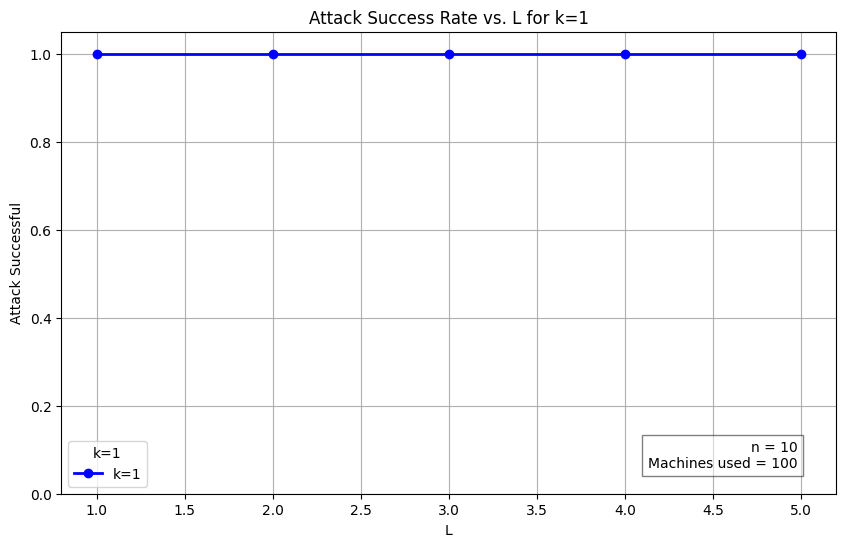

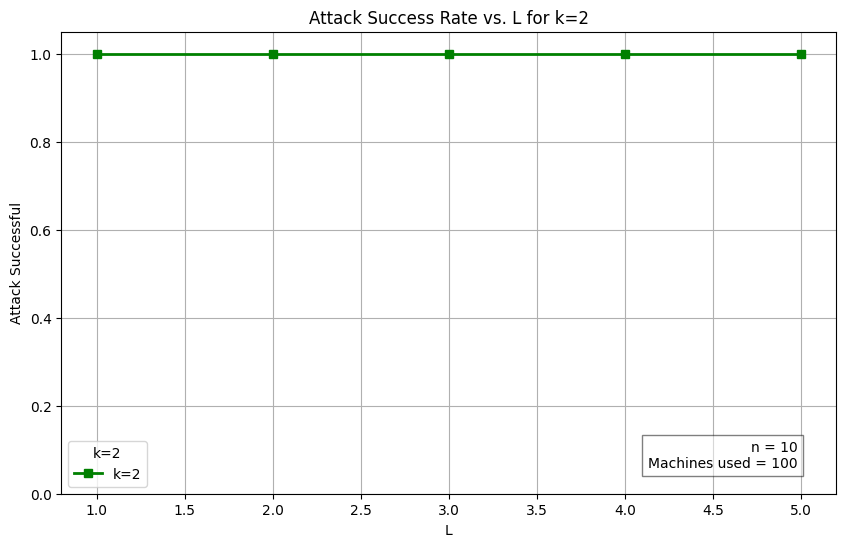

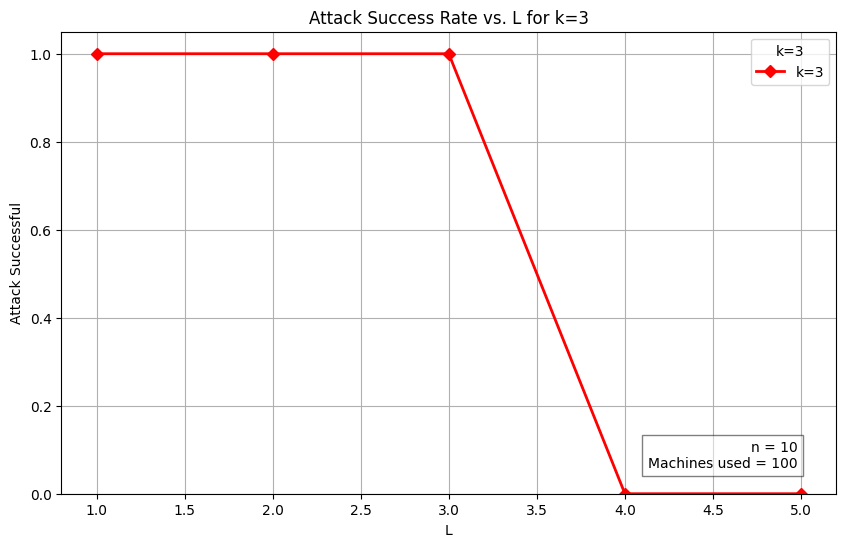

In [74]:
import matplotlib.pyplot as plt

def plot_experiment_results(df_results):
    # Define colors and markers for different values of k
    colors = {1: 'blue', 2: 'green', 3: 'red'}
    markers = {1: 'o', 2: 's', 3: 'D'}  # 'o' = circle, 's' = square, 'D' = diamond

    # Plotting a separate graph for each k
    for k in df_results['k'].unique():
        subset = df_results[df_results['k'] == k]

        plt.figure(figsize=(10, 6))
        plt.plot(subset['l'], subset['attack_successful'], label=f'k={k}', color=colors[k], marker=markers[k], linestyle='-', linewidth=2)

        # Add labels and title
        plt.xlabel('L')
        plt.ylabel('Attack Successful')
        plt.title(f'Attack Success Rate vs. L for k={k}')

        # Add legend
        plt.legend(title=f'k={k}')

        # Add text box with n and number_of_machines
        n_value = subset['n'].iloc[0]  # Assuming n is constant for this subset
        machine_used = subset['number_of_machines'].iloc[0]  # Assuming number_of_machines is constant
        textstr = f'n = {n_value}\nMachines used = {machine_used}'
        plt.gca().text(0.95, 0.05, textstr, transform=plt.gca().transAxes,
                       fontsize=10, verticalalignment='bottom', horizontalalignment='right',
                       bbox=dict(facecolor='white', alpha=0.5))

        plt.ylim(0, 1.05)
        # Show grid
        plt.grid(True)

        # Show the plot
        plt.show()

# Example usage with the DataFrame df_results
plot_experiment_results(df_results)
